In [137]:
import sys
from pathlib import Path

import cv2
import numpy as np
from typing import Set

from src.regiongrower import RegionGrower

sys.path.append(str(Path.cwd().parent))

In [138]:
from pathlib import Path

from src.face import FaceDetector
from src.mask import MaskHandler
from src.projectUtils import Utils
from src.superpixels import SuperpixelExtractor, FeatureExtractor
from src.regiongrower import RegionGrower

In [139]:
fd = FaceDetector("../assets/lbfmodel.yaml")
mh = MaskHandler()

IMAGE_PATH = Path('test_images/helen1.jpg')

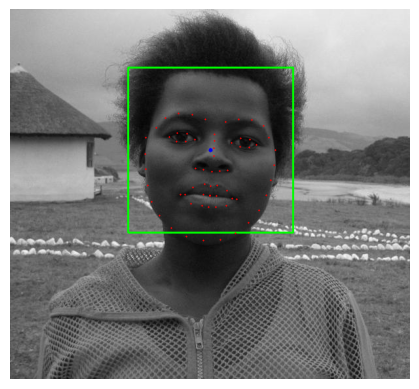

In [140]:
img_rgb, _, _, landmarks_all_faces = fd.detect(IMAGE_PATH)
Utils.display(img_rgb)

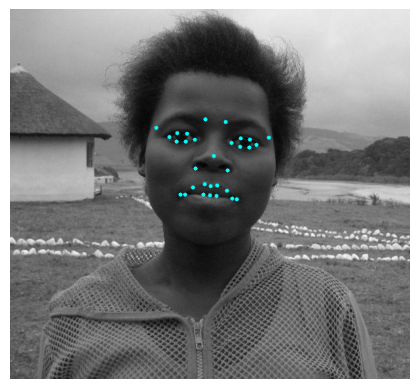

1


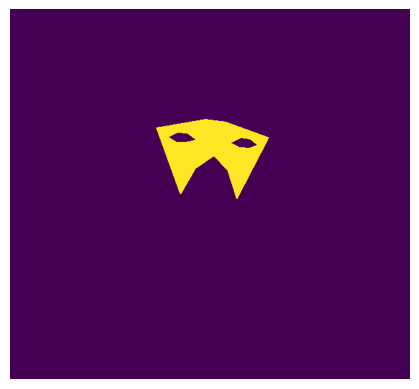

In [141]:
masked_img, selected_pts = mh.get_mask_points(IMAGE_PATH, landmarks_all_faces)
Utils.display(masked_img)

masks, masked_imgs = mh.build_masks(IMAGE_PATH, selected_pts)
print(len(masks))
Utils.display(masks[0])

1


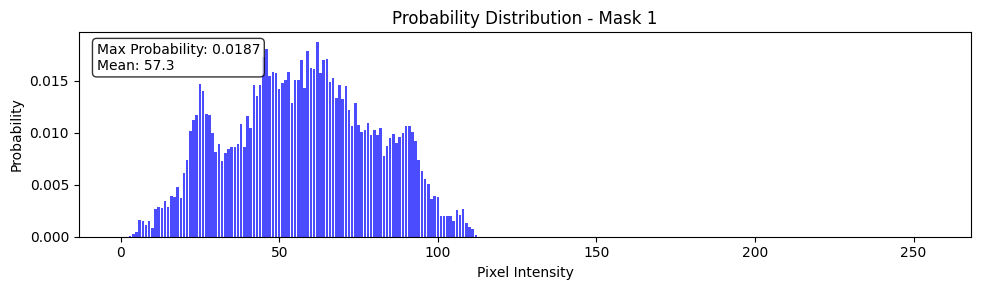

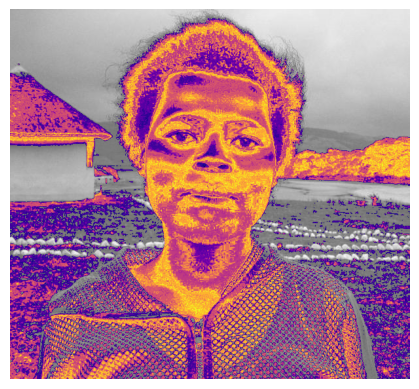

In [142]:
intensity_histograms = mh.get_intensity_histograms(IMAGE_PATH, masks)

print(len(intensity_histograms))
Utils.visualize_histograms(intensity_histograms)
Utils.apply_intensity_probability_map(IMAGE_PATH, intensity_histograms[0])

1
1
1


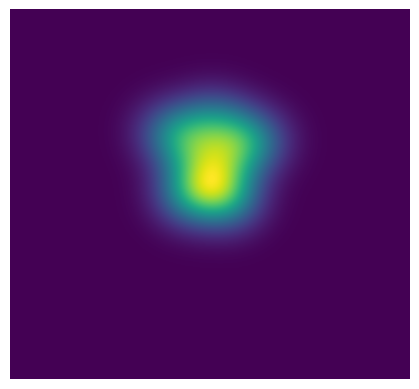

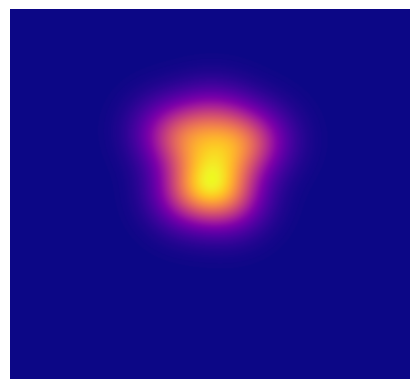

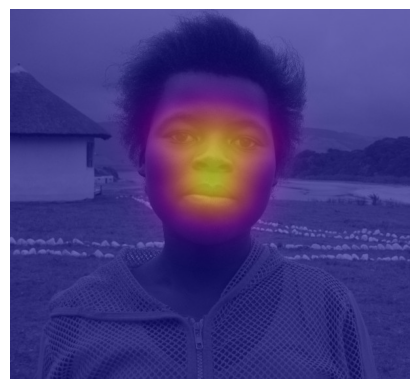

In [143]:
prior_face_masks, heatmaps, heatmaps_blended = mh.get_prior_face_masks(IMAGE_PATH, selected_pts)

print(len(prior_face_masks))
print(len(heatmaps))
print(len(heatmaps_blended))

idx = 0

Utils.display(prior_face_masks[idx])
Utils.display(heatmaps[idx])
Utils.display(heatmaps_blended[idx])

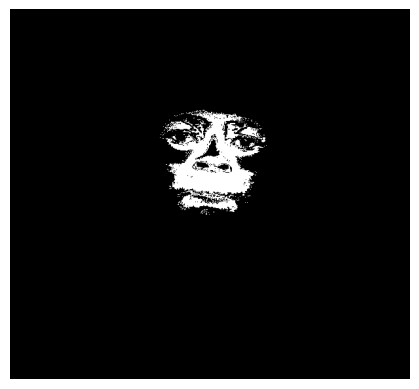

In [144]:
alpha = 0.9
lambda_ = 0.008

skin_pixel_maps = mh.get_skin_pixel_maps(IMAGE_PATH, intensity_histograms, prior_face_masks, alpha, lambda_)

for i in skin_pixel_maps:
    Utils.display(i, cmap="gray")

In [145]:
spe = SuperpixelExtractor()
fe = FeatureExtractor()

slic, contoured_img, labels, num_superpixels = spe.get_slic_superpixels(IMAGE_PATH)

In [146]:
def get_seed_superpixels_from_mask(pixel_mask: np.ndarray, labels: np.ndarray, overlap_threshold: float = 0.5) -> Set[int]:
    seed_labels = set()
    unique_labels = np.unique(labels)
    
    if -1 in unique_labels:
        unique_labels = unique_labels[unique_labels != -1]
    if 0 in unique_labels:
        unique_labels = unique_labels[unique_labels != 0]
        
    for label in unique_labels:
        superpixel_mask = (labels == label)
        binary_pixel_mask = (pixel_mask > 0)
        intersection = np.logical_and(superpixel_mask, binary_pixel_mask)
        superpixel_size = np.sum(superpixel_mask)
        
        if superpixel_size == 0: continue
        
        overlap_ratio = np.sum(intersection) / superpixel_size
        if overlap_ratio >= overlap_threshold:
            seed_labels.add(int(label))
    return seed_labels

overlap_threshold = 0.5
seed_mask_labels = get_seed_superpixels_from_mask(skin_pixel_maps[0], labels, overlap_threshold)

1
1
1


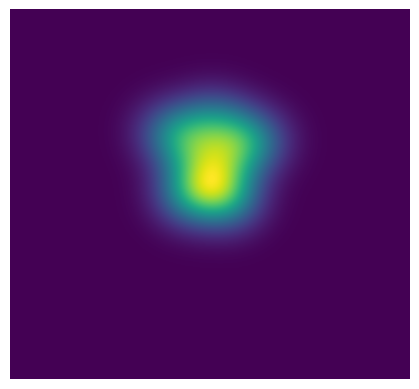

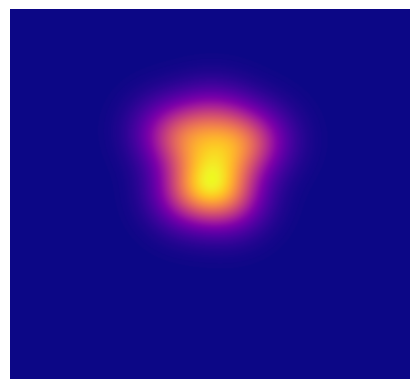

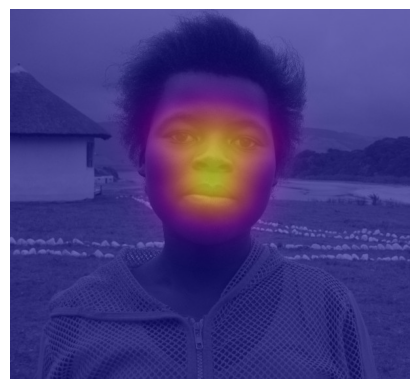

In [147]:
prior_face_masks, heatmaps, heatmaps_blended = mh.get_prior_face_masks(IMAGE_PATH, selected_pts)

print(len(prior_face_masks))
print(len(heatmaps))
print(len(heatmaps_blended))

idx = 0

Utils.display(prior_face_masks[idx])
Utils.display(heatmaps[idx])
Utils.display(heatmaps_blended[idx])

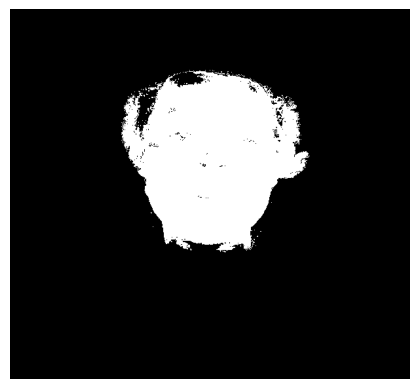

In [148]:
alpha = 0.8851773188792857
lambda_ = 0.0006174988170846915

skin_pixel_maps = mh.get_skin_pixel_maps(IMAGE_PATH, intensity_histograms, prior_face_masks, alpha, lambda_)

for i in skin_pixel_maps:
    Utils.display(i, cmap="gray")

In [149]:
spe = SuperpixelExtractor()
fe = FeatureExtractor()

slic, contoured_img, labels, num_superpixels = spe.get_slic_superpixels(IMAGE_PATH)

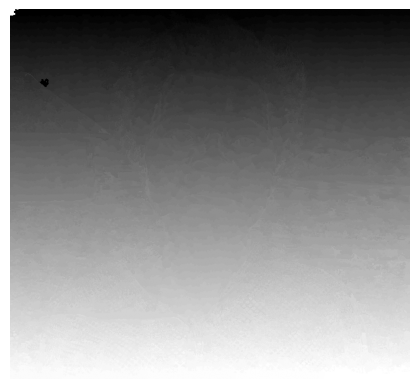

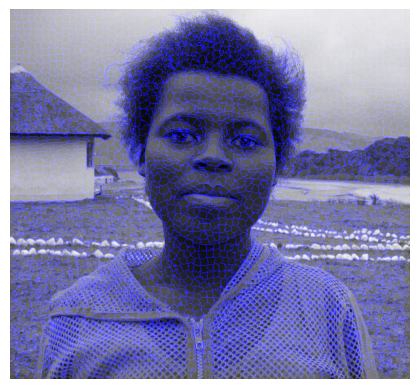

In [150]:
Utils.display(labels, cmap="gray")
Utils.display(contoured_img)

In [151]:
feature_vectors_sp = fe.extract_all_features_superpixels(IMAGE_PATH, slic)
print(feature_vectors_sp)

[{'label': 0, 'mean_intensity': 147.77570093457945, 'std_intensity': 2.431523545368494, 'entropy': 3.1085840874922583, 'lacunarity_vector': array([0.86915888, 0.69158879, 0.8317757 , 0.78504673, 0.75700935,
       0.76635514, 0.95327103, 0.85981308, 0.85981308, 0.90654206,
       0.87850467, 0.94392523, 0.87850467, 0.85981308, 0.98130841,
       0.93457944, 0.91588785, 0.90654206, 0.96261682, 0.94392523,
       0.95327103, 0.92523364, 0.82242991, 0.77570093, 0.71962617,
       0.75700935, 0.78504673, 0.8411215 , 0.93457944, 0.91588785,
       0.82242991, 0.85981308, 0.88785047, 0.91588785, 0.87850467,
       0.91588785, 0.96261682, 0.97196262, 0.96261682, 0.87850467,
       0.96261682, 0.88785047, 0.97196262, 0.97196262])}, {'label': 1, 'mean_intensity': 170.73636363636365, 'std_intensity': 1.5936081001486853, 'entropy': 2.376018806390931, 'lacunarity_vector': array([0.92727273, 0.65454545, 0.8       , 0.77272727, 0.85454545,
       0.84545455, 0.97272727, 0.94545455, 0.91818182, 0.872

In [152]:
feature_vector = fe.extract_all_features_mask(IMAGE_PATH, masks[0])
print(feature_vector)

{'mean_intensity': 57.32188602190458, 'std_intensity': 22.874524970749963, 'entropy': 3.517819306603381, 'lacunarity_vector': array([0.8894561 , 0.52116206, 0.9155374 , 0.82429924, 0.56506404,
       0.91423798, 0.95396324, 0.7066085 , 0.93939113, 0.94236124,
       0.95117876, 0.73816596, 0.93911268, 0.96073882, 0.98227214,
       0.86374606, 0.98217932, 0.95758307, 0.98292185, 0.8593837 ,
       0.98069426, 0.98459254, 0.83664377, 0.58093559, 0.90514201,
       0.8171524 , 0.55476146, 0.92398366, 0.95155003, 0.73965101,
       0.93883423, 0.94755894, 0.95099313, 0.72090217, 0.94421756,
       0.96705031, 0.98338593, 0.86727306, 0.9780026 , 0.97364025,
       0.97837386, 0.88008168, 0.98152961, 0.9849638 ])}


In [153]:
individual_feature_probs, norm_params = fe.calculate_feature_learned_probability(feature_vectors_sp, feature_vector)

In [154]:
print(individual_feature_probs)

[{'label': 0, 'mean_intensity': 0.5027638273622859, 'std_intensity': 0.5122661571014485, 'entropy': 0.9200976614088133, 'lacunarity_vector': 0.8347297635321089}, {'label': 1, 'mean_intensity': 0.5022042988024392, 'std_intensity': 0.5117818739428682, 'entropy': 0.7059556042539238, 'lacunarity_vector': 0.8297543598993032}, {'label': 2, 'mean_intensity': 0.50217603125953, 'std_intensity': 0.5114832299830774, 'entropy': 0.6449982363432851, 'lacunarity_vector': 0.7571577730843337}, {'label': 3, 'mean_intensity': 0.5021183144941667, 'std_intensity': 0.5117827119699441, 'entropy': 0.7063891697063327, 'lacunarity_vector': 0.9000417059048869}, {'label': 4, 'mean_intensity': 0.5020448443955425, 'std_intensity': 0.5116321482390106, 'entropy': 0.6763660440582318, 'lacunarity_vector': 0.8716451613458038}, {'label': 5, 'mean_intensity': 0.501964870792216, 'std_intensity': 0.5118063218251707, 'entropy': 0.7089570030059327, 'lacunarity_vector': 0.934264797131322}, {'label': 6, 'mean_intensity': 0.5019

In [155]:
combined_probability = fe.calculate_combined_probability(individual_feature_probs)
print(combined_probability)

[{'label': 0, 'p': 0.19780602463460673}, {'label': 1, 'p': 0.1505539864128076}, {'label': 2, 'p': 0.1254389157621367}, {'label': 3, 'p': 0.1633797923811238}, {'label': 4, 'p': 0.1514334640646045}, {'label': 5, 'p': 0.17016445715758732}, {'label': 6, 'p': 0.15466903740591498}, {'label': 7, 'p': 0.14405901685548625}, {'label': 8, 'p': 0.1402708872240164}, {'label': 9, 'p': 0.1334209026691514}, {'label': 10, 'p': 0.13291361704977006}, {'label': 11, 'p': 0.12537949868527562}, {'label': 12, 'p': 0.12613126876118066}, {'label': 13, 'p': 0.1326781396056763}, {'label': 14, 'p': 0.13989634183401561}, {'label': 15, 'p': 0.12750094183741076}, {'label': 16, 'p': 0.13910801257205122}, {'label': 17, 'p': 0.1333564788975055}, {'label': 18, 'p': 0.11920157549794459}, {'label': 19, 'p': 0.14680282275095122}, {'label': 20, 'p': 0.12495104452915977}, {'label': 21, 'p': 0.1374698534696842}, {'label': 22, 'p': 0.15486938340605394}, {'label': 23, 'p': 0.1447621367156772}, {'label': 24, 'p': 0.17574660372038

In [172]:
region_grower = RegionGrower(kappa=0.7899)

In [173]:
seed_mask_for_labels = skin_pixel_maps[0].astype(bool)
unique_labels_in_mask = np.unique(labels[seed_mask_for_labels])
actual_seed_labels = set(int(lbl) for lbl in unique_labels_in_mask if lbl != -1)
print(len(actual_seed_labels))

601


In [174]:
initial_combined_probs_list = [{'label': item['label'], 'initial_combined_prob': item['p']} for item in combined_probability]

In [175]:
final_skin_labels = region_grower.grow(feature_vectors_sp, initial_combined_probs_list, labels, seed_mask_labels, norm_params)

region growing with 119 initial seed labels


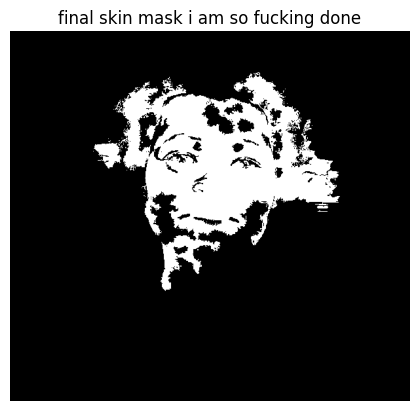

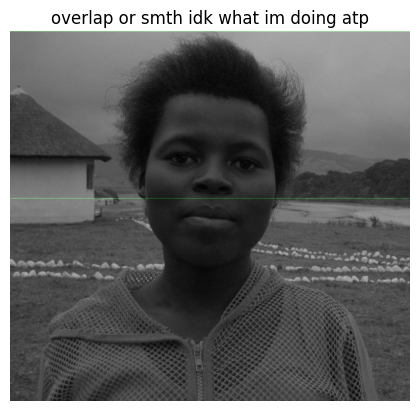

In [176]:
skin_region_mask = np.zeros_like(labels, dtype=np.uint8)
for label_val in final_skin_labels:
    skin_region_mask[labels == label_val] = 255
Utils.display(skin_region_mask, title='final skin mask i am so fucking done', cmap='gray')

img_gray_orig = cv2.imread(IMAGE_PATH, cv2.IMREAD_GRAYSCALE)
img_rgb_orig = cv2.cvtColor(img_gray_orig, cv2.COLOR_GRAY2RGB)
overlay = np.zeros_like(img_rgb_orig)
overlay[skin_region_mask] = [0,255,0]
result_img = cv2.addWeighted(img_rgb_orig, 0.7, overlay, 0.3, 0)
Utils.display(result_img, title='overlap or smth idk what im doing atp')